Epoch 1/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 2/100
167/167 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/100
167/167 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/100
167/167 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 9/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/100
167/167 [==============================] - 1s 4ms/step - loss: 0.0010 - val_lo

167/167 [==============================] - 1s 4ms/step - loss: 9.2935e-04 - val_loss: 0.0010
Epoch 79/100
167/167 [==============================] - 1s 5ms/step - loss: 9.0732e-04 - val_loss: 9.8913e-04
Epoch 80/100
167/167 [==============================] - 1s 5ms/step - loss: 9.1419e-04 - val_loss: 0.0010
Epoch 81/100
167/167 [==============================] - 1s 5ms/step - loss: 9.3308e-04 - val_loss: 0.0010
Epoch 82/100
167/167 [==============================] - 1s 5ms/step - loss: 9.1212e-04 - val_loss: 9.9619e-04
Epoch 83/100
167/167 [==============================] - 1s 5ms/step - loss: 9.2077e-04 - val_loss: 9.7132e-04
Epoch 84/100
167/167 [==============================] - 1s 5ms/step - loss: 9.1153e-04 - val_loss: 9.9973e-04
Epoch 85/100
167/167 [==============================] - 1s 5ms/step - loss: 9.0461e-04 - val_loss: 9.9086e-04
Epoch 86/100
167/167 [==============================] - 1s 5ms/step - loss: 8.9742e-04 - val_loss: 9.9681e-04
Epoch 87/100
167/167 [=============

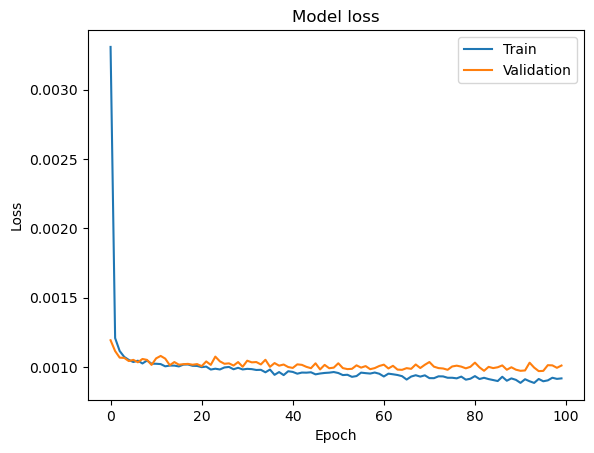

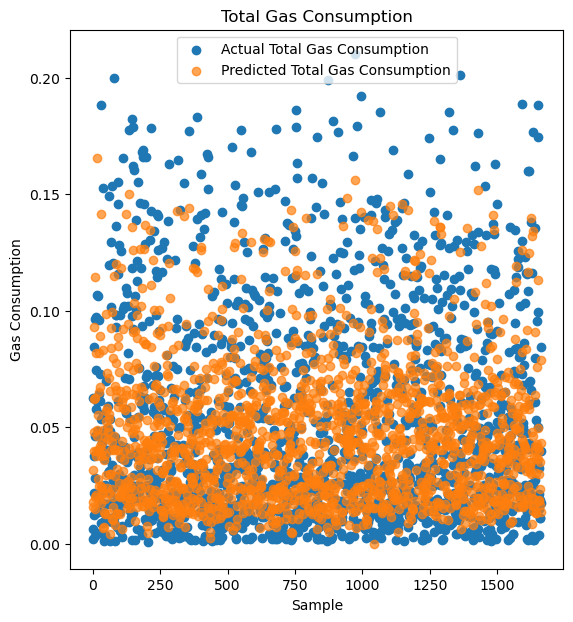

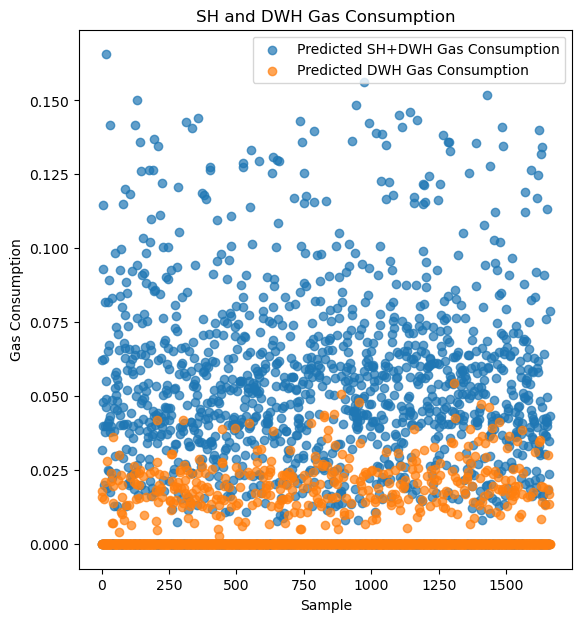

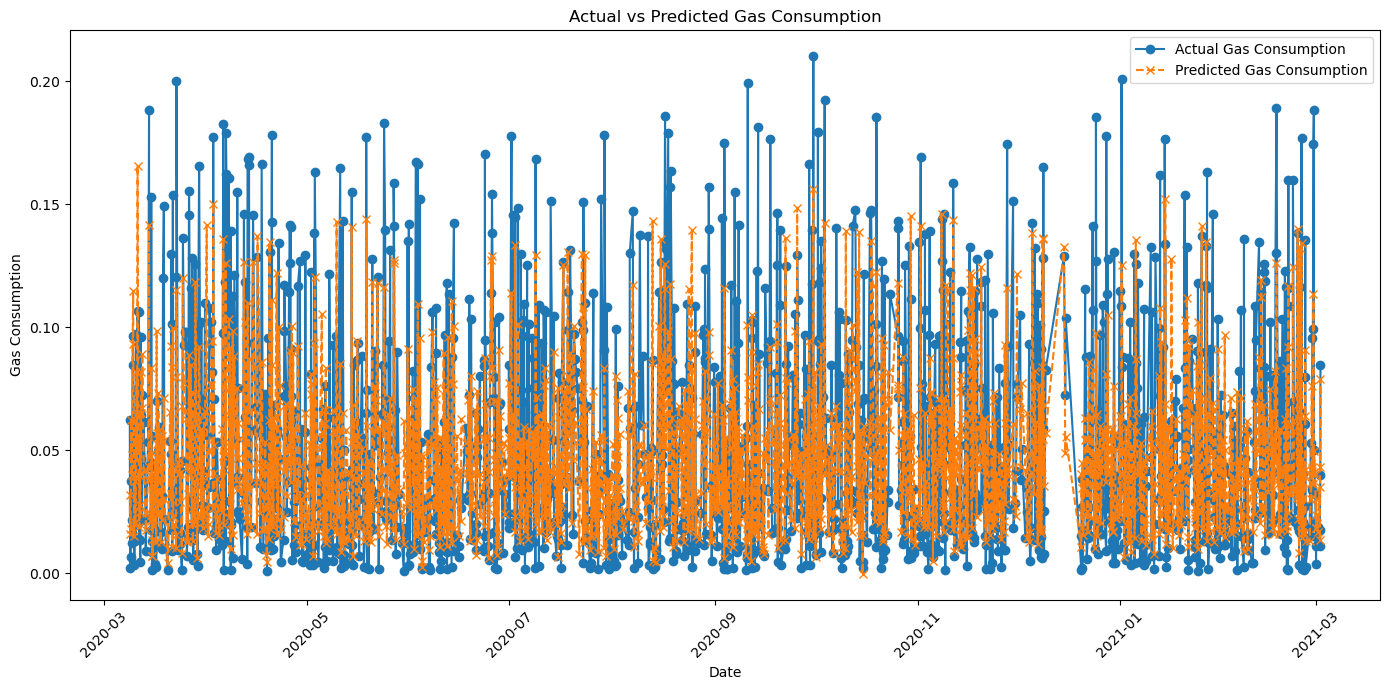

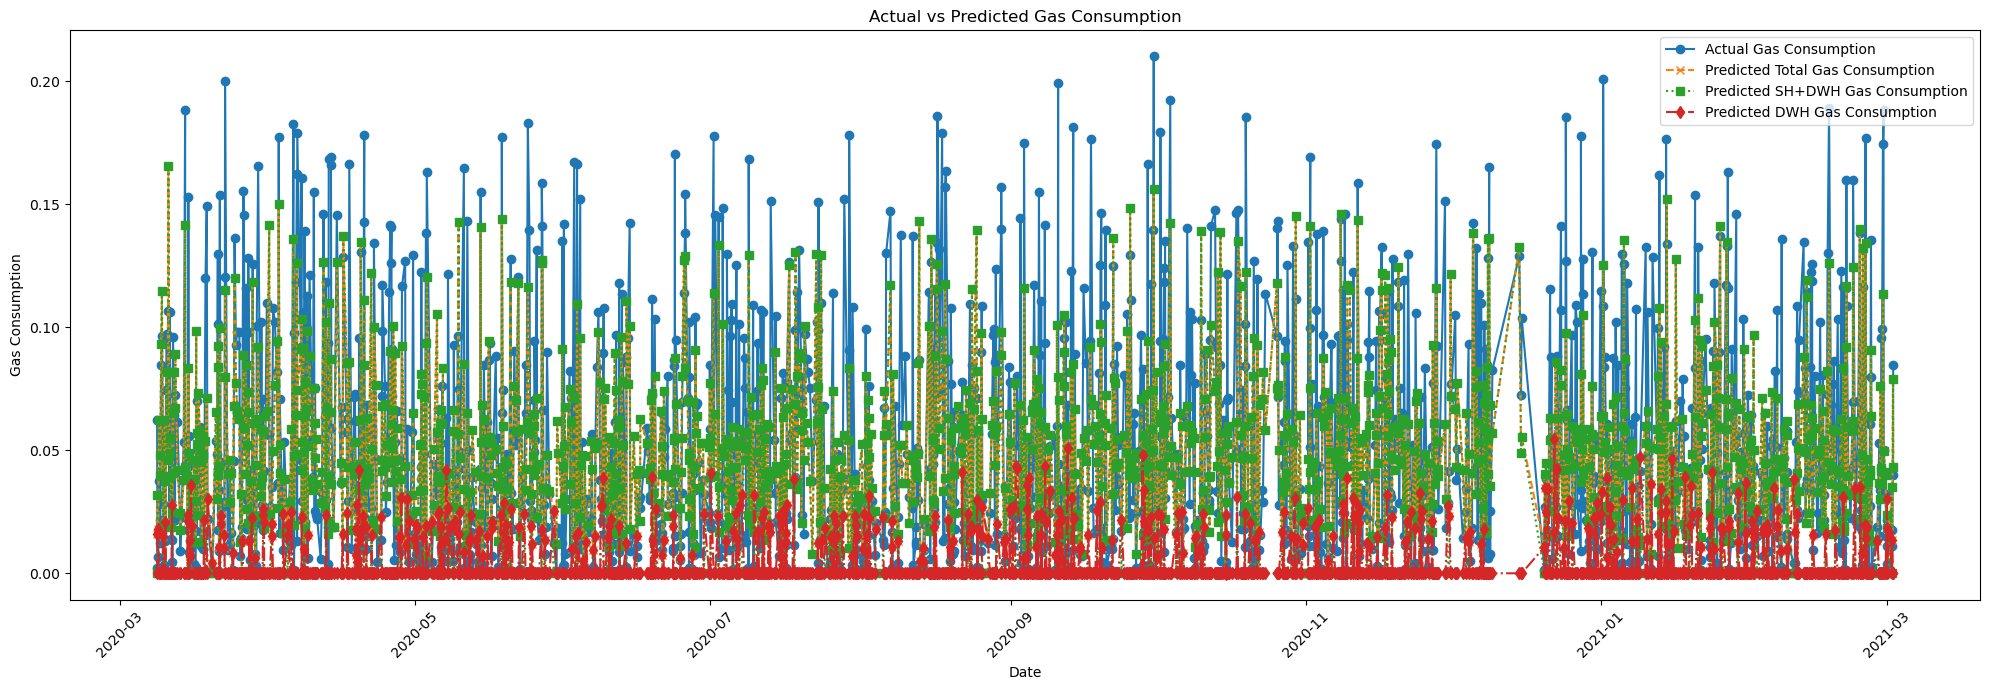

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Load the data
daily_stat = pd.read_csv('hourly_stat.csv').dropna()

# Ensure the date column is parsed as datetime
daily_stat['date'] = pd.to_datetime(daily_stat['date'])

# Extract features and target
features = daily_stat[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']]
target = daily_stat['Gas_mean']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data while keeping the date for plotting
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.2, random_state=42)

# Ensure dates are sorted
date_test = pd.Series(date_test).sort_values().reset_index(drop=True)
date_train = pd.Series(date_train).sort_values().reset_index(drop=True)


# Reshape data for CNN input (samples, time steps, features)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train_cnn, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predict gas consumption on the test set
predictions = model.predict(X_test_cnn).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

# Assuming SH periods are marked in your dataset, create boolean masks for SH and DWH periods
external_temp_test = X_test[:, 4] * scaler.scale_[4] + scaler.mean_[4]  # Reverse normalization for external temp
sh_dwh_periods = external_temp_test < 15
dwh_periods = external_temp_test >= 15

# For simplicity, assume gas consumption for SH and DWH can be linearly decomposed
sh_dwh_contributions = predictions * sh_dwh_periods
dwh_contributions = predictions * dwh_periods

# Plot training loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Compare actual vs predicted SH and DWH gas consumption
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label='Actual Total Gas Consumption')
plt.scatter(range(len(y_test)), predictions, label='Predicted Total Gas Consumption', alpha=0.7)
plt.title('Total Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), sh_dwh_contributions, label='Predicted SH+DWH Gas Consumption', alpha=0.7)
plt.scatter(range(len(y_test)), dwh_contributions, label='Predicted DWH Gas Consumption', alpha=0.7)
plt.title('SH and DWH Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

# Plot actual vs predicted gas consumption over time
plt.figure(figsize=(14, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, predictions, label='Predicted Gas Consumption', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot actual vs predicted gas consumption over time with SH and DWH contributions
plt.figure(figsize=(20, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, predictions, label='Predicted Total Gas Consumption', marker='x', linestyle='--')
plt.plot(date_test, sh_dwh_contributions, label='Predicted SH+DWH Gas Consumption', marker='s', linestyle=':')
plt.plot(date_test, dwh_contributions, label='Predicted DWH Gas Consumption', marker='d', linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
